In [ ]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Subset


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

tr_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform)
te_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                               download=True, transform=transform)

indices = list(range(5000))
tr_subset = Subset(tr_set, indices)
indices = list(range(2500))
te_subset = Subset(te_set, indices)

#Split ratios for validation and testing sets
# validation_ratio = 0.2
# te_ratio = 0.1
# samples = len(full_set)
# val_samples = int(validation_ratio * samples)
# te_samples = int(te_ratio * samples)
# tr_samples = samples - val_samples - te_samples

#Split dataset into training, validation, and testing sets
# tr_set, val_set, te_set = torch.utils.data.random_split(full_set,
#                                                              [tr_samples, val_samples, te_samples])

#Loads the training set
tr_loader = torch.utils.data.DataLoader(tr_subset, batch_size=batch_size,
                                           shuffle=True, num_workers=2)

# Load validation set
# val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)

# Load test set
te_loader = torch.utils.data.DataLoader(te_subset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(len(tr_set), len(te_set))

Files already downloaded and verified
Files already downloaded and verified
50000 10000


In [ ]:
import numpy as np

#Function displays image
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ConNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def fit(self, device, tr_loader, optimizer, criterion, epochs):
        self.train()

        for epoch in range(epochs):
            for X_tr, y_tr in tr_loader:
                X_tr, y_tr = X_tr.to(device), y_tr.to(device)
                optimizer.zero_grad()
                output = self(X_tr)
                loss = criterion(output, y_tr)
                loss.backward()
                optimizer.step()

    def test(self, device, te_loader):
        self.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for X_te, y_te in te_loader:
                output = self(X_te)
                _, predicted = torch.max(output.data, 1)
                total += y_te.size(0)
                correct += (predicted == y_te).sum().item()
        return correct/total

model = ConNeuralNetwork()

In [ ]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.fit(device, tr_loader, optimizer, criterion, epochs=10)

print('Finished Training')

print(model.test(device, te_loader))

Finished Training
0.496


In [50]:
def errors_for_train_sizes_cnn(tr_set, te_loader, train_sizes):
    tr_err_cnn = [] # training error for CNN
    te_err_cnn = [] # testing error for CNN

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    for size in train_sizes:
        indices = list(range(size))
        tr_subset = Subset(tr_set, indices)
        tr_loader = torch.utils.data.DataLoader(tr_subset, batch_size=4, shuffle=True, num_workers=2)
        
        model = ConNeuralNetwork()

        # Train the model
        model.fit(device, tr_loader, optimizer, criterion, epochs=10)
        
        # Check accuracy for model on training and testing data
        tr_acc = model.test(device, tr_loader)
        te_acc = model.test(device, te_loader)
        
        tr_err_cnn.append(1 - tr_acc)
        te_err_cnn.append(1 - te_acc)

    return tr_err_cnn, te_err_cnn

In [51]:
def plot_errors_for_train_sizes_cnn(tr_err_cnn, te_err_cnn, train_sizes):

    plt.semilogx(train_sizes, tr_err_cnn, label='tr_cnn', marker='x', color='orange')
    plt.semilogx(train_sizes, te_err_cnn, label='te_cnn', linestyle='--', marker='x', color='orange')

    plt.xlabel('Num. Training Data Points')
    plt.ylabel('Error Rate')

    plt.legend()

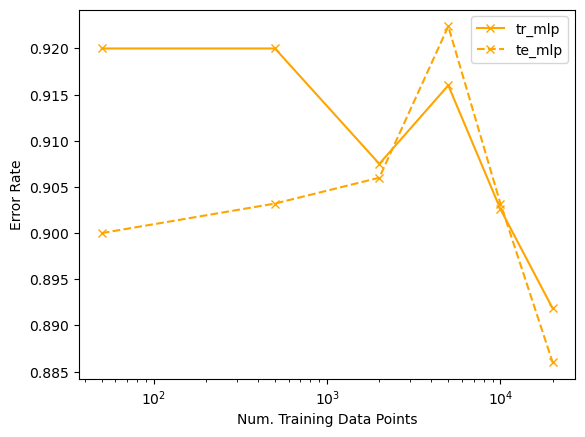

In [53]:
train_sizes = [50, 500, 2000, 5000, 10000, 20000]
tr_err, te_err = errors_for_train_sizes_cnn(tr_set, te_loader, train_sizes)
plot_errors_for_train_sizes_cnn(tr_err, te_err, train_sizes)